# UNION PPO distillation
Distill a POP-style teacher set (CNet192 checkpoints) into a single CNet192 student using **logits-mixture** targets.

**Single-channel only**: states are `(1,6,7)` mover-POV, fed to the net as `(B,1,6,7)`.


In [1]:
# Cell 1: imports + seeds (single-channel only)

from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Sequence, Tuple

import math
import random

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

from C4.connect4_env import Connect4Env
from C4.CNet192 import CNet192, load_cnet192, save_cnet192

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

N_ACTIONS = 7

# --- global seeds ---
SEED = 666
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

# Optional: set torch thread counts (useful on CPU; harmless on GPU)
# If you see dataloader/CPU bottlenecks, bump these modestly.
try:
    torch.set_num_threads(max(1, os.cpu_count() // 2))
    torch.set_num_interop_threads(max(1, os.cpu_count() // 2))
except Exception:
    pass


Using device: cuda


In [2]:
# Cell 2: define teachers (ONLY INPUT)
HOF_METASCORES = {
    #"PPO_Models/MIX_11.pt": 0.781000,
    "PPO_Models/MIX_12a.pt": 0.586667,
    #"PPO_Models/MIX_12b.pt": 0.507500,
}


In [3]:
# Cell 3: load teacher CNet192 checkpoints + normalized mixture weights

TEACHER_PATHS: List[str] = list(HOF_METASCORES.keys())
TEACHER_NAMES: List[str] = [Path(p).stem for p in TEACHER_PATHS]

# normalize weights from metascores (positive, sum=1)
w = np.array([float(HOF_METASCORES[p]) for p in TEACHER_PATHS], dtype=np.float64)
w = np.maximum(w, 1e-8)
w = w / w.sum()
TEACHER_WEIGHTS: np.ndarray = w.astype(np.float64)

TEACHERS: Dict[str, torch.nn.Module] = {}

for name, path in zip(TEACHER_NAMES, TEACHER_PATHS):
    model, ckpt = load_cnet192(path=path, device=DEVICE, strict=True)
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    TEACHERS[name] = model
    print(f"Loaded teacher: {name} from {path}  (w={TEACHER_WEIGHTS[TEACHER_NAMES.index(name)]:.4f})")

assert len(TEACHERS) == len(TEACHER_NAMES) == len(TEACHER_WEIGHTS)


Loaded teacher: MIX_12a from PPO_Models/MIX_12a.pt  (w=1.0000)


In [4]:
# Cell 4: logits-mixture target distribution (legal-masked softmax per teacher)

NEG_INF = -1e9

@torch.inference_mode()
def _teacher_logits_np(teacher: torch.nn.Module, state_1x6x7: np.ndarray) -> np.ndarray:
    """state_1x6x7: (1,6,7) float32 POV -> logits (7,) float32."""
    x = torch.as_tensor(state_1x6x7, dtype=torch.float32, device=DEVICE).unsqueeze(0)  # (1,1,6,7)
    out = teacher(x)
    logits = out[0] if isinstance(out, (tuple, list)) else out
    return logits[0].detach().float().cpu().numpy()

def ensemble_mixture_probs(state_np: np.ndarray, legal_actions: Sequence[int], temperature: float = 1.0) -> np.ndarray:
    """Return probs[7] = sum_i w_i * softmax(masked_logits_i / T)."""
    legal = [int(a) for a in legal_actions]
    if not legal:
        return np.zeros(N_ACTIONS, dtype=np.float32)

    legal_mask = np.zeros(N_ACTIONS, dtype=bool)
    legal_mask[legal] = True

    mix = np.zeros(N_ACTIONS, dtype=np.float64)

    T = float(temperature) if temperature and temperature > 0 else 1.0

    for name, w in zip(TEACHER_NAMES, TEACHER_WEIGHTS):
        teacher = TEACHERS[name]
        logits = _teacher_logits_np(teacher, state_np).astype(np.float64, copy=False)  # (7,)

        # mask illegal BEFORE softmax
        masked = logits.copy()
        masked[~legal_mask] = NEG_INF

        # stable softmax on legal only
        m = np.max(masked[legal])
        ex = np.zeros(N_ACTIONS, dtype=np.float64)
        ex[legal] = np.exp((masked[legal] - m) / T)
        s = float(ex[legal].sum())
        if s <= 0.0 or not np.isfinite(s):
            continue
        p = ex / s  # already 0 for illegal
        mix += float(w) * p

    # final renorm + hard-zero illegal
    mix[~legal_mask] = 0.0
    s = float(mix.sum())
    if s <= 0.0 or not np.isfinite(s):
        # fallback uniform over legal
        out = np.zeros(N_ACTIONS, dtype=np.float32)
        out[legal] = 1.0 / len(legal)
        return out

    mix = mix / s
    return mix.astype(np.float32)


In [5]:
# Cell 5: dataset + rollout generator (with tqdm)

class DistillDataset(Dataset):
    def __init__(self, states: np.ndarray, targets: np.ndarray):
        assert states.ndim == 4 and states.shape[1:] == (1, 6, 7)
        assert targets.ndim == 2 and targets.shape[1] == N_ACTIONS
        self.states = states.astype(np.float32, copy=False)
        self.targets = targets.astype(np.float32, copy=False)

    def __len__(self) -> int:
        return int(self.states.shape[0])

    def __getitem__(self, idx: int):
        return self.states[idx], self.targets[idx]

def generate_distill_data(
    n_episodes: int = 200,
    max_moves: int = 42,
    max_samples: int = 80_000,
    seed: int = 666,
    temperature: float = 1.0,
) -> DistillDataset:
    """
    Let the teacher-mixture play in Connect4Env and record (state, target_probs).

    Env state is already single-channel POV: (1,6,7).
    Target is logits-mixture probs over legal moves.
    """
    rng = np.random.default_rng(int(seed))
    random.seed(int(seed))
    torch.manual_seed(int(seed))
    if DEVICE.type == "cuda":
        torch.cuda.manual_seed_all(int(seed))

    states: List[np.ndarray] = []
    targets: List[np.ndarray] = []
    total_samples = 0

    pbar = tqdm(range(int(n_episodes)), desc="Generating rollouts", leave=True)

    for _ in pbar:
        env = Connect4Env()
        env.reset()
        done = False
        moves = 0

        while (not done) and moves < int(max_moves) and total_samples < int(max_samples):
            legal = env.available_actions()
            if not legal:
                break

            s = env.get_state(perspective=env.current_player)  # (1,6,7) float32 POV
            s = np.asarray(s, dtype=np.float32)

            y = ensemble_mixture_probs(s, legal_actions=legal, temperature=float(temperature))  # (7,)

            states.append(s)  # already (1,6,7)
            targets.append(y)
            total_samples += 1

            a = int(y.argmax())
            if a not in legal:
                a = int(rng.choice(legal))

            _, _, done = env.step(a)
            moves += 1

        pbar.set_postfix(samples=total_samples)

        if total_samples >= int(max_samples):
            break

    states_arr = np.stack(states, axis=0)   # (N,1,6,7)
    targets_arr = np.stack(targets, axis=0) # (N,7)

    print(f"Final distill dataset: states {states_arr.shape}, targets {targets_arr.shape}")
    return DistillDataset(states_arr, targets_arr)


In [6]:
# Cell 6: build dataset + loaders

EPISODES = 3000
MAX_SAMPLES = 175_000
TEMPERATURE = 1.0

distill_dataset = generate_distill_data(
    n_episodes=EPISODES,
    max_moves=42,
    max_samples=MAX_SAMPLES,
    seed=SEED,
    temperature=TEMPERATURE,
)

print("Dataset size:", len(distill_dataset))

# split train/val
val_frac = 0.05
N = len(distill_dataset)
idx = np.arange(N)
rng = np.random.default_rng(SEED)
rng.shuffle(idx)

n_val = max(1, int(N * val_frac))
val_idx = idx[:n_val]
train_idx = idx[n_val:]

train_states = distill_dataset.states[train_idx]
train_targets = distill_dataset.targets[train_idx]
val_states = distill_dataset.states[val_idx]
val_targets = distill_dataset.targets[val_idx]

train_ds = DistillDataset(train_states, train_targets)
val_ds   = DistillDataset(val_states,   val_targets)

BATCH_SIZE = 256
NUM_WORKERS = 0  # set >0 if your env+numpy overhead is low and you want faster loading

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Generating rollouts:   0%|          | 0/3000 [00:00<?, ?it/s]

Final distill dataset: states (51000, 1, 6, 7), targets (51000, 7)
Dataset size: 51000
Train batches: 190, Val batches: 10


In [7]:
# Cell 7: student + training loop (tqdm + loss histories + correct save_cnet192 usage)

student = CNet192(in_channels=1, use_mid_3x3=True).to(DEVICE)

LR = 1.2e-4
GRAD_CLIP = 0.5
NUM_EPOCHS = 12

optimizer = torch.optim.Adam(student.parameters(), lr=LR)

# KLDivLoss expects input=log_probs, target=probs => computes KL(target || student)
criterion = torch.nn.KLDivLoss(reduction="batchmean")

def run_epoch(loader, train: bool, desc: str) -> float:
    student.train(bool(train))

    total_loss = 0.0
    total_items = 0

    it = tqdm(loader, desc=desc, leave=False)
    for states, targets in it:
        states  = states.to(DEVICE, non_blocking=True)   # (B,1,6,7)
        targets = targets.to(DEVICE, non_blocking=True)  # (B,7)

        if train:
            optimizer.zero_grad(set_to_none=True)

        out = student(states)
        logits = out[0] if isinstance(out, (tuple, list)) else out

        log_probs = F.log_softmax(logits, dim=-1)
        loss = criterion(log_probs, targets)

        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student.parameters(), GRAD_CLIP)
            optimizer.step()

        bs = int(states.size(0))
        total_loss += float(loss.item()) * bs
        total_items += bs

        it.set_postfix(loss=float(loss.item()))

    return total_loss / max(1, total_items)

# ---- checkpoint meta ----
meta_base = {
    "source": "UNION_PPO_distill_logits_mixture",
    "teachers": list(HOF_METASCORES.keys()),
    "metascores": dict(HOF_METASCORES),
    "teacher_names": list(TEACHER_NAMES),
    "teacher_weights": TEACHER_WEIGHTS.tolist(),
    "seed": int(SEED),
    "num_samples": int(len(distill_dataset)),
    "temperature": float(TEMPERATURE),
    "lr": float(LR),
    "batch_size": int(BATCH_SIZE),
}

best_val = math.inf
best_path = Path("PPO_Models/DIST_UNION_best.pt")
last_path = Path("PPO_Models/DIST_UNION_last.pt")

train_loss_history: List[float] = []
val_loss_history: List[float] = []

for epoch in range(1, NUM_EPOCHS + 1):
    tr = run_epoch(train_loader, train=True,  desc=f"Train {epoch}/{NUM_EPOCHS}")
    va = run_epoch(val_loader,   train=False, desc=f"Val   {epoch}/{NUM_EPOCHS}")

    train_loss_history.append(float(tr))
    val_loss_history.append(float(va))

    print(f"[Epoch {epoch:03d}] train={tr:.6f}  val={va:.6f}")

    if va < best_val:
        best_val = float(va)
        meta = dict(meta_base)
        meta.update({"tag": "best_val", "epoch": int(epoch), "best_val_loss": float(best_val)})
        save_cnet192(best_path, student, cfg=None, **meta)
        print(f"  -> saved best: {best_path}")

# save final
meta = dict(meta_base)
meta.update({"tag": "final", "epoch": int(NUM_EPOCHS), "best_val_loss": float(best_val)})
save_cnet192(last_path, student, cfg=None, **meta)
print("Saved final:", last_path)



Train 1/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   1/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 001] train=0.671590  val=0.018564
  -> saved best: PPO_Models\DIST_UNION_best.pt


Train 2/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   2/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 002] train=0.004228  val=0.001073
  -> saved best: PPO_Models\DIST_UNION_best.pt


Train 3/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   3/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 003] train=0.000637  val=0.000365
  -> saved best: PPO_Models\DIST_UNION_best.pt


Train 4/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   4/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 004] train=0.000257  val=0.000178
  -> saved best: PPO_Models\DIST_UNION_best.pt


Train 5/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   5/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 005] train=0.000144  val=0.000119
  -> saved best: PPO_Models\DIST_UNION_best.pt


Train 6/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   6/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 006] train=0.000352  val=0.002252


Train 7/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   7/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 007] train=0.000350  val=0.000071
  -> saved best: PPO_Models\DIST_UNION_best.pt


Train 8/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   8/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 008] train=0.000063  val=0.000055
  -> saved best: PPO_Models\DIST_UNION_best.pt


Train 9/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   9/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 009] train=0.000062  val=0.000133


Train 10/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   10/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 010] train=0.000187  val=0.000351


Train 11/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   11/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 011] train=0.000089  val=0.000036
  -> saved best: PPO_Models\DIST_UNION_best.pt


Train 12/12:   0%|          | 0/190 [00:00<?, ?it/s]

Val   12/12:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 012] train=0.000036  val=0.000214
Saved final: PPO_Models\DIST_UNION_last.pt


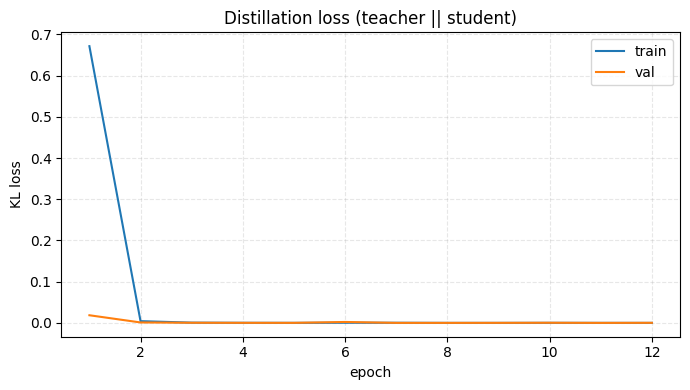

In [8]:
# Cell 8: plot losses

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.plot(np.arange(1, len(train_loss_history)+1), train_loss_history, label="train")
ax.plot(np.arange(1, len(val_loss_history)+1), val_loss_history, label="val")
ax.set_xlabel("epoch")
ax.set_ylabel("KL loss")
ax.set_title("Distillation loss (teacher || student)")
ax.legend()
ax.grid(True, ls="--", alpha=0.3)
fig.tight_layout()
plt.show()
